In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math

# ML libraries
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping  # To stop training early if val loss stops decreasing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.stattools import pacf


import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
tesla=pd.read_csv('interpolated_tesla_df.csv',index_col='Date')

In [3]:
tesla.head()

,Value
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-03,1.228500


## Artificial Neural Network (Multi-Layer Perceptron)

The MLP (Multi-Layer Perceptron) model consists of multiple layers of interconnected nodes or "neurons" that process input data and produce output. The MLP model is a **feedforward network**, meaning the data flows in one direction through the layers, from the input layer to the output layer. Each neuron in the network is connected to neurons in the previous and next layers, and each connection has an associated weight that is adjusted during training to optimize the model's performance on the task at hand.

In [4]:
data=tesla.values
data.shape

(3946, 1)

In [5]:
# Separate train and test data
train_length = int(len(data) * 0.9)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Train length:  3551
Shape of Train and Test data:  (3551, 1) (395, 1)


In [6]:
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Shape of Train and Test data:  (3551, 1) (395, 1)


In [7]:
# define a function to split a univariate sequence into supervised learning [Input and Output]
def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback -1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        b = dataset[i+lookback, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [8]:
pacf_value = pacf(data, nlags=10)

lag = 0
# collect lag values greater than 10% correlation 
for x in pacf_value:
    if x > 0.1:
        lag += 1
    else:
        break
print('Selected look_back (or lag = ): ', lag)

Selected look_back (or lag = ):  2


In [9]:
train_X, train_y = create_dataset(train_data, lag)
test_X, test_y = create_dataset(test_data, lag)

print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (3548, 2) (3548,)
Shape of test_X and test_y:  (392, 2) (392,)


In [10]:
print(test_data[:5])            # original data
for x in range(len(train_X[:5])):
    print(test_X[x], test_y[x], )            # trainX and trainY after lookback

[[28.50933266]
 [28.50200081]
 [28.65222295]
 [28.80244509]
 [28.95266724]]
[28.50933266 28.50200081] 28.65222295125325
[28.50200081 28.65222295] 28.80244509379069
[28.65222295 28.80244509] 28.952667236328125
[28.80244509 28.95266724] 33.66666793823242
[28.95266724 33.66666794] 35.95000076293945


In [11]:
np.random.seed(7)

In [12]:
model1 = Sequential()
model1.add(Dense(64, input_dim = lag, activation='relu', name= "1st_hidden"))

model1.add(Dense(1, name = 'Output_layer', activation='linear'))
model1.compile(loss="mean_squared_error", optimizer="adam")
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_hidden (Dense)          (None, 64)                192       
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [13]:
history1 = model1.fit(train_X, train_y, epochs = 200, batch_size = 64, callbacks=[EarlyStopping(patience=3)], verbose = 1, shuffle=False, 
                    validation_split=0.1)

Epoch 1/200
50/50 [==============================] - 2s 32ms/step - loss: 39.7775 - val_loss: 6.6204
Epoch 2/200
50/50 [==============================] - 1s 30ms/step - loss: 0.8263 - val_loss: 1.5202
Epoch 3/200
50/50 [==============================] - 2s 31ms/step - loss: 0.1763 - val_loss: 1.4699
Epoch 4/200
50/50 [==============================] - 1s 29ms/step - loss: 0.1593 - val_loss: 1.4919
Epoch 5/200
50/50 [==============================] - 2s 32ms/step - loss: 0.1477 - val_loss: 1.4677
Epoch 6/200
50/50 [==============================] - 1s 30ms/step - loss: 0.1464 - val_loss: 1.4550
Epoch 7/200
50/50 [==============================] - 2s 31ms/step - loss: 0.1428 - val_loss: 1.4374
Epoch 8/200
50/50 [==============================] - 1s 29ms/step - loss: 0.1391 - val_loss: 1.4210
Epoch 9/200
50/50 [==============================] - 1s 30ms/step - loss: 0.1359 - val_loss: 1.4085
Epoch 10/200
50/50 [==============================] - 1s 30ms/step - loss: 0.1329 - val_loss: 1.399

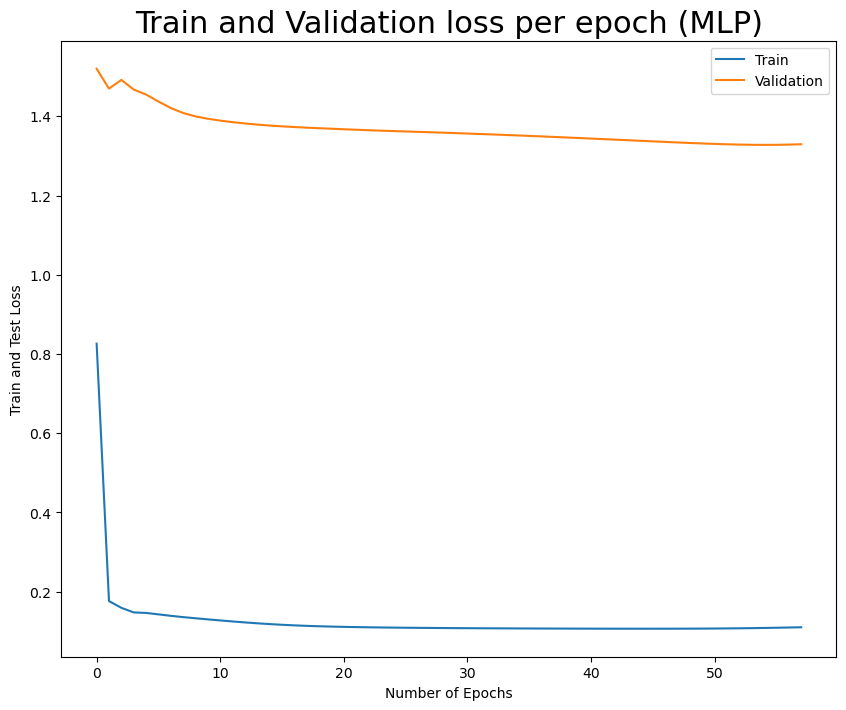

In [14]:
# plot history1
plt.clf
plt.figure(figsize=(10,8))
plt.plot(history1.history['loss'][1:], label='Train')
plt.plot(history1.history['val_loss'][1:], label='Validation')
plt.xlabel('Number of Epochs')
plt.ylabel('Train and Test Loss')
plt.title('Train and Validation loss per epoch (MLP)',fontsize=22)
plt.savefig('./data/Train and Validation loss MLP.png')

plt.legend()
plt.show()

In [27]:
# Make prediction
testPredict = model1.predict(test_X)
trainPredict =model1.predict(train_X)

111/111 [==============================] - 0s 3ms/step


In [16]:
# calculate root mean squared error

testScore = math.sqrt(mean_squared_error(test_y[:], testPredict[:,0]))
print(' Root Mean Squared Error: %.2f RMSE' % (testScore))

 Root Mean Squared Error: 5.87 RMSE


In [17]:
# R-squared
r2 = r2_score(test_y[:], testPredict[:,0])
print('R-squared:', r2)

R-squared: 0.994373790865723


In [21]:
#Mean Absolute Error (MAE)
mae_test_score = mean_absolute_error(test_y, testPredict)

print('Test MAE: ',mae_test_score)

Test MAE:  3.94587170510065


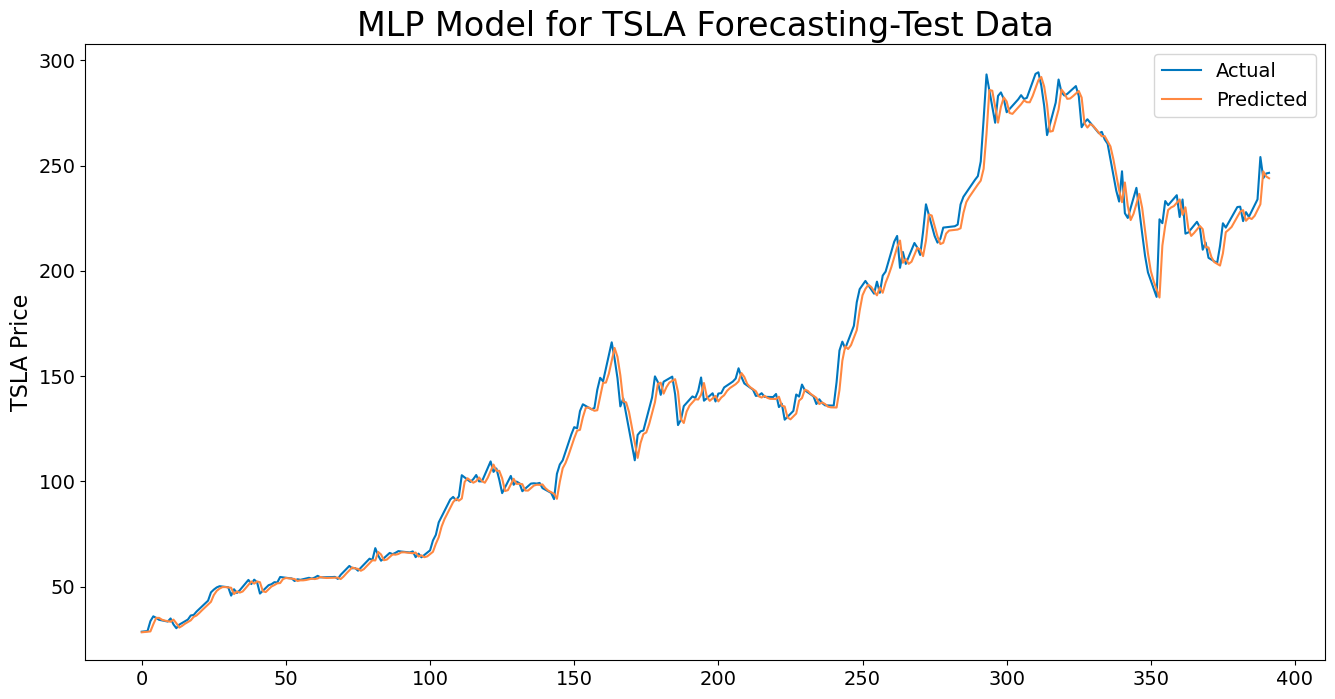

In [22]:
#plotting Test and Predicted data

plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})
plt.plot(test_y[:], '#0077be',label = 'Actual')
plt.plot(testPredict[:,0], '#ff8841',label = 'Predicted')
plt.title('MLP Model for TSLA Forecasting-Test Data', fontsize=24)
plt.ylabel('TSLA Price',fontsize=16)
#plt.xlabel('Time Steps [in Days] ')
plt.legend()
plt.savefig('./data/MLP_Model.png')

plt.show()

##  RNN - Recurrent Neural Network

In [ ]:
data = tesla.values
print('Shape of data: ', data.shape)

In [ ]:
# Separate train and test data
train_length = int(len(data) * 0.9)
train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

In [ ]:
# split a univariate sequence into supervised learning [Input and Output]
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
lag = 2  # Empirically we have choosen
n_features = 1

In [ ]:
train_X, train_y = split_sequence(train_data, lag)
test_X, test_y = split_sequence(test_data, lag)

In [ ]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

In [ ]:
#6.5 Reshape train_X and test_X to 3-Dimension

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [ ]:
# New shape of train_X and test_X
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

In [ ]:
# define model2
model2 = Sequential()
model2.add(SimpleRNN(64, activation='relu', return_sequences=False, input_shape=(lag, n_features)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

In [ ]:
# fit model2
history2 = model2.fit(train_X, train_y, epochs = 200, callbacks=[EarlyStopping(patience=3)], batch_size=64, verbose=1, validation_split= 0.1)

In [ ]:
# plot history2
plt.plot(history2.history['loss'][2:])
plt.plot(history2.history['val_loss'][1:])
plt.title('Train and Validation loss per epochs (RNN)',fontsize=24)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])

plt.savefig('./data/Train and Validation loss RNN.png')
plt.show()

In [ ]:
train_predict = model2.predict(train_X)
test_predict = model2.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

In [ ]:
# calculate root mean squared error

testScore = math.sqrt(mean_squared_error(test_y[:], test_predict[:,0]))
print(' Root Mean Squared Error: %.2f RMSE' % (testScore))

In [ ]:
# calculate R squared
r2 = r2_score(test_y[:], test_predict[:,0])

print('R-squared:', r2)

In [ ]:
#Mean Absolute Error (MAE)

mae_train_score = mean_absolute_error(train_y, train_predict)
mae_test_score = mean_absolute_error(test_y, test_predict)

print('Train and Test MAE: ',mae_train_score,mae_test_score)

## Plotting the predition vs real values

NameError: name 'test_predict' is not defined

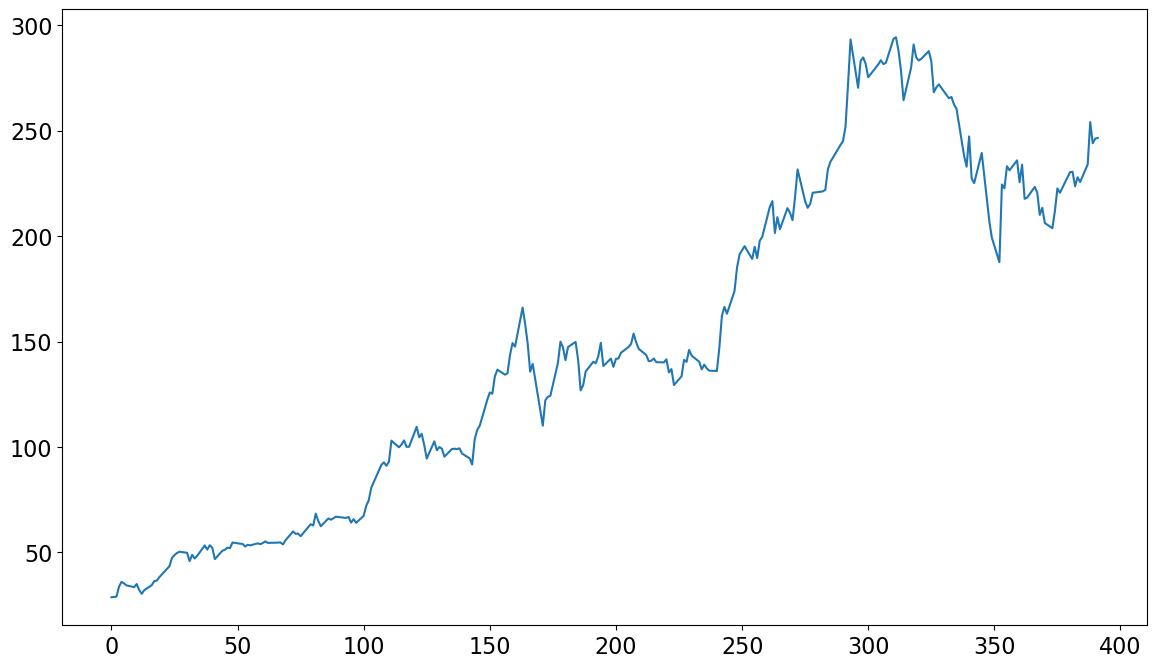

In [23]:
#Train Data
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_y[:], label = 'Actual')
plt.plot(test_predict, label = 'Predicted')
plt.xlabel('Time in days')
plt.ylabel('Adjusted Close price')
plt.title('TSLA prediction using Simple RNN - Test data')
plt.legend()
plt.show()

NameError: name 'test_predict' is not defined

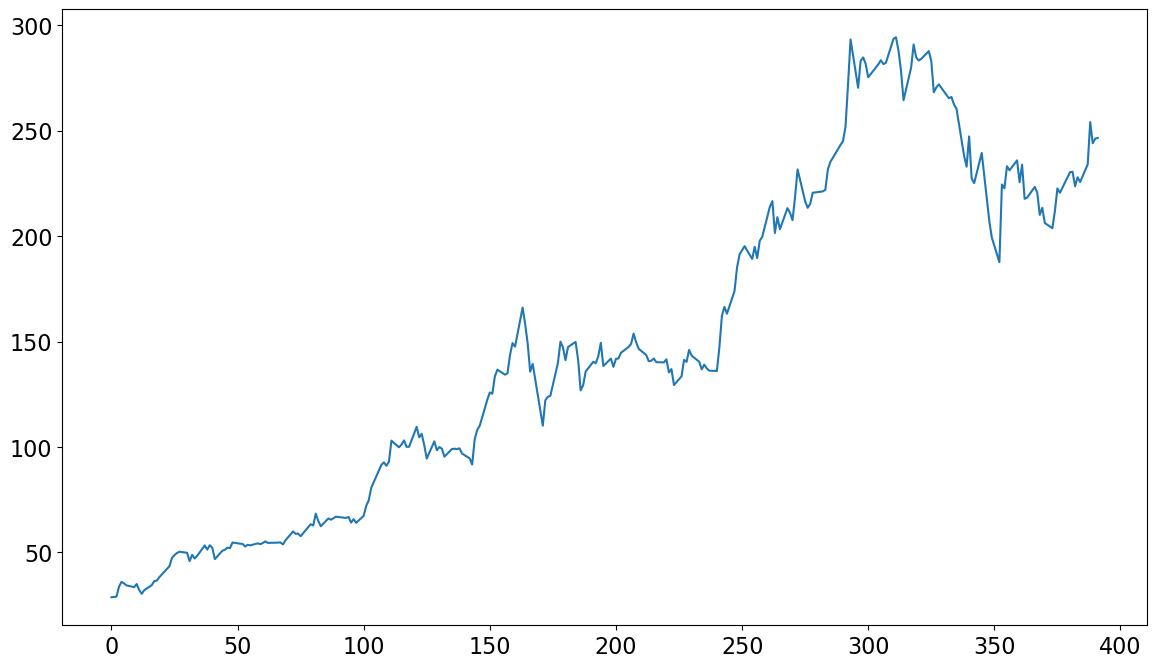

In [24]:
# Test Data
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_y, label = 'Actual')
plt.plot(test_predict, label = 'Predicted')
plt.xlabel('Time in days')
plt.ylabel('Adjusted Close price')
plt.title('Tesla price prediction using Simple RNN - Test data')
plt.legend()
plt.show()

In [28]:
train_residuals=(train_y.flatten()-trainPredict.flatten())

In [29]:
test_residuals=(test_y.flatten()-testPredict.flatten())

In [31]:
trainPredict.shape, train_residuals.shape,train_data.shape

((3548, 1), (3548,), (3551, 1))

In [43]:
testPredict.shape, test_residuals.shape,test_data.shape

((395,), (395,), (395, 1))

In [33]:
trainPredict=np.insert(trainPredict, 0, [np.nan, np.nan,np.nan])

In [34]:
train_residuals=np.insert(train_residuals, 0, [np.nan, np.nan,np.nan])

In [39]:
test_residuals=np.insert(test_residuals, 0, [np.nan, np.nan, np.nan])

In [42]:
testPredict=np.insert(testPredict, 0, [np.nan, np.nan,np.nan])

In [44]:
predict = np.concatenate((trainPredict, testPredict), axis=0)
residuals=np.concatenate((train_residuals, test_residuals), axis=0)

In [45]:
predict.shape, residuals.shape, tesla.shape

((3946,), (3946,), (3946, 1))

In [46]:
tesla.shape

(3946, 1)

In [47]:
tesla['predict']=predict
tesla['residuals']=residuals

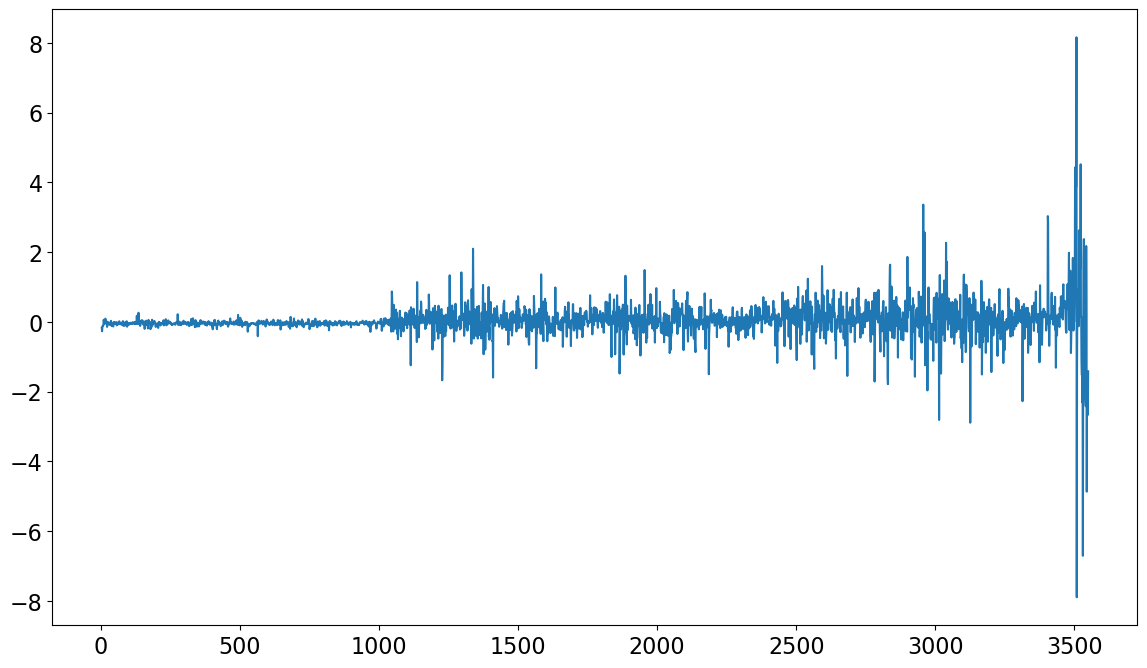

In [48]:
plt.plot(train_residuals)

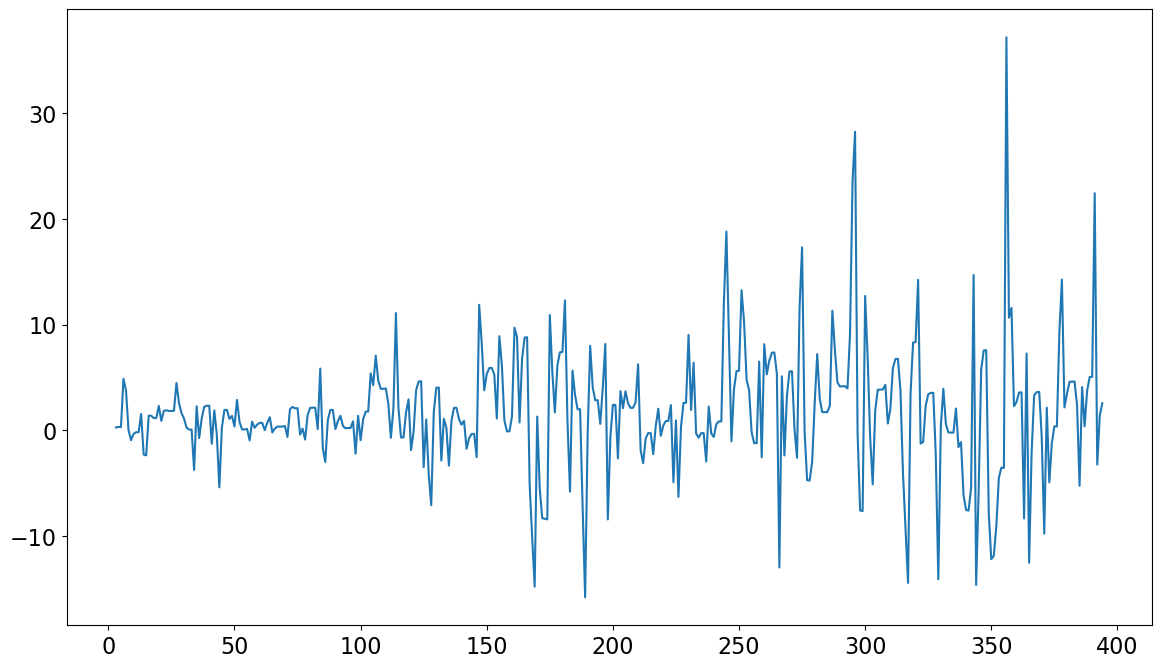

In [49]:
plt.plot(test_residuals)

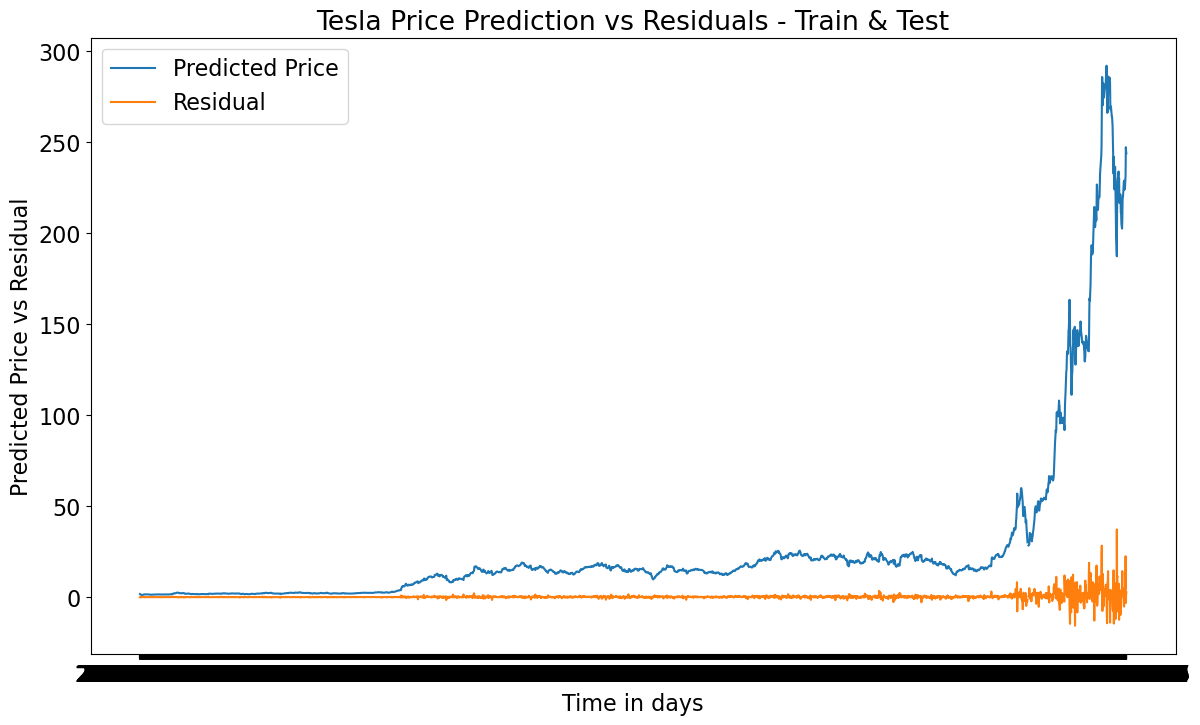

In [56]:
# All Data
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})


plt.plot(tesla['predict'], label = 'Predicted Price')
plt.plot(tesla['residuals'], label='Residual')

plt.xlabel('Time in days')
plt.ylabel('Predicted Price vs Residual')
plt.title('Tesla Price Prediction vs Residuals - Train & Test')
plt.legend()

plt.savefig('./data/Predict+residuals_MLP.png')

plt.show()

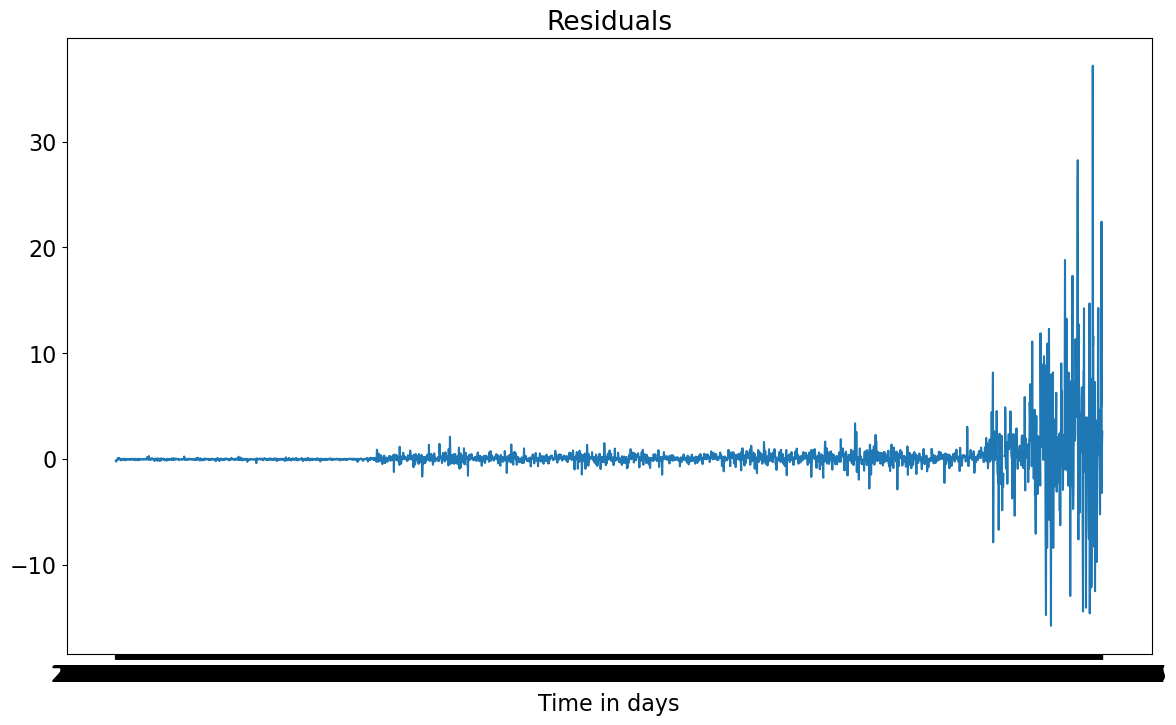

In [60]:
plt.plot(tesla['residuals'], label='Residual')
plt.xlabel('Time in days')

plt.title('Residuals')

plt.savefig('./data/residuals_MLP.png')

plt.show()


In [53]:
tesla

,Value,predict,residuals
Date,,,
2010-06-29,1.592667,NaN,NaN
2010-06-30,1.588667,NaN,NaN
2010-07-01,1.464000,NaN,NaN
2010-07-02,1.280000,1.633252,-0.169252
2010-07-03,1.228500,1.546172,-0.266172
...,...,...,...
2021-04-13,254.106674,228.923965,5.069366
2021-04-14,244.076660,231.677216,22.429459
2021-04-15,246.283340,247.299271,-3.222610


In [54]:
tesla = tesla.rename(columns={'Value': 'Adj Close'})

In [55]:
tesla.to_csv('tesla_all_dates_prediction_residuals.csv')